# <font color='blue'> Analysis of modal projections of different populations: braking event vs normal driving  

For a typical subject </font>

<br>

<hr>

## <font color='blue'> Description </font>

This notebook first builds a KL finite approximations of the EEG segments stochastic processe. It first build this approximation over all the data, i.e. normal driving epochs or segments(no event) and braking epochs (event).

Then we take the projection of the driving epochs and braking epochs field on the eigenmodes basis, and study the differnece. Can we quantify difference? Can we cluster in this space? 

Next: Or fit a spatio-temporal model on some subject and see the residuals in the rest, can this shed light on the intra subject variability? 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import pandas as pd 

In [2]:
def preprocess_epochs(df_eeg,nSample,nn_channels,time_int):
    NPeeg = []
    nSample = int(df_eeg.shape[0]/nn_channels)
    for i in range(nSample):
        for k in range(nn_channels):
            NPeeg.append(np.asarray(df_eeg)[i * 59 + k,:time_int])
    NPeeg = np.asarray(NPeeg)
    return NPeeg

In [3]:
def compute_mu_t(NPeegC,nn_channels):
    mu_t = []
    x = np.arange(0, NPeegC.shape[0])
    for k in range(nn_channels):
        n= x[(x % nn_channels == k) ] 
        mu_t.append(NPeegC[n,:].mean(axis=0)) 
    mu_t = np.array(mu_t)
    return mu_t

In [4]:
def transform_mesh_format(NPeegC,mu_t,nSample,nn_channels):
    values = []
    for k in range(nSample):
        start = k * nn_channels
        end = start + nn_channels
        values.append( (NPeegC[start:end,:] - mu_t).T)
    return values

## <font color='blue'> Import data for one subject </font>

(Below same procedure for all subjects and events)

In [5]:
path_data_mat = '/Users/obando_c/Documents/Neuro/EmergencyBraking/data/'
file_name = "Raw/VPja.mat" # VPja.mat ; VPbax.mat
df_eeg_balanced_file = path_data_mat + 'fromJupyter/df_eeg.csv' # Corresponds to VPja
#/Users/obando_c/Documents/Neuro/EmergencyBraking/data/fromJupyter/df_eeg_balanced.csv

### Import 3D position of EEG electrodes
**mnt**  &emsp; &emsp; &emsp;  &emsp; &emsp; &emsp; &nbsp;*Structure defining electrode positions*  <br>

In [6]:
with h5py.File(path_data_mat + file_name, 'r') as f:
    mnt = f.get('mnt')
    #print("Items in mnt", list(mnt.items()) )
    #x_pos_allChannels = np.array(mnt.get('x'))
    #y_pos_allChannels = np.array(mnt.get('y'))
    pos3d_allChannels = np.array(mnt.get('pos_3d')) # coord in 3D

pos3d_eegChannels = pos3d_allChannels[np.delete(np.arange(61), [0, 5])]

### Import EEG data

Import EEG data aquired from 59 scalp sites, select **nn_channels** number of electrodes or channels and time length **time_int**.

**time_int**  &emsp; &emsp; &emsp;  &emsp; &emsp; &emsp; &nbsp;*Length of time interval (default 320 points, 1 point step correspond to 5ms)*  <br>
**nn_channels**  &emsp; &emsp; &emsp; &emsp; &nbsp;*Number of EEG electrodes or channels (max=59)*  <br>

In [7]:
df_eeg_balanced = pd.read_csv( df_eeg_balanced_file )
df_eeg_brake = df_eeg_balanced[df_eeg_balanced['event']==1.0].drop(['seq_id', 'event','param'],axis=1)
df_eeg_drive = df_eeg_balanced[df_eeg_balanced['event']==0.0].drop(['seq_id', 'event','param'],axis=1)

time_int = df_eeg_brake.shape[1] #
nn_channels = 59

nSample_b = int(df_eeg_brake.shape[0]/59)
nSample_d = int(df_eeg_drive.shape[0]/59)

In [189]:
df_eeg_brake.shape

(13570, 320)

In [8]:
NPeeg_b = preprocess_epochs(df_eeg_brake,nSample_b,nn_channels,time_int)
NPeeg_d = preprocess_epochs(df_eeg_drive,nSample_d,nn_channels,time_int)

In [194]:
NPeeg_d.shape

(13570, 320)

In [9]:
NPeeg = np.concatenate((NPeeg_b,NPeeg_d), axis=0)
nSample = nSample_b + nSample_d

### Data normalization
Remove the temporal mean of the signals to normalize them around 0.

At each time point, compute the average value of the sginal for each electorde. 

In [10]:
NPeegC = NPeeg-NPeeg.mean(axis=1).reshape(-1,1) # 

In [12]:
mu_t = compute_mu_t(NPeegC,nn_channels)

### Build spatio-temporal mesh

In [13]:
spatiotemp_mesh = []
for p in pos3d_eegChannels[:nn_channels]: #
    xi, yi, zi = tuple(p)
    for ti in range(time_int):
        spatiotemp_mesh.append([xi, yi, zi, ti])

### Transfomr EEG data in spatio-temporal mesh format 

Each entry of the object must correspond to the enties in the spatio temporal mesh

In [14]:
values = transform_mesh_format(NPeegC,mu_t,nSample,nn_channels)

##  <font color='blue'>FPCA </font>

In [15]:
# OpenTurns:
import openturns as ot
dim_ch_in = 1 # corresponds to process_sample
dim_ch_out = 1 # corresponds to  field
process_sample = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), nSample, dim_ch_in) 
field          = ot.Field(ot.Mesh(spatiotemp_mesh), dim_ch_out) #le 1 correspond a la dimension du champ en sortie
for k in range(process_sample.getSize()):
    aux = []
    for j in range(nn_channels):
        aux.append(values[k][:,j])
    field.setValues(np.array(aux).reshape(-1,1))
    process_sample[k] = field

### KarhunenLoeve </font>

In [16]:
s = 0.0 # 
w_v = np.ones(nn_channels*time_int) # verticesWeights
algo = ot.KarhunenLoeveSVDAlgorithm(process_sample,w_v, s) #0.0 (=s) correspond au threshold sur les valeurs propres
algo.run()

fPCA     = algo.getResult() # The structure containing all the results of the Fredholm problem
Xi       = fPCA.project(process_sample) # Project a function or a field on the eigenmodes basis.
XiLambda = Xi * ot.Point([np.sqrt(x) for x in fPCA.getEigenValues()])

### Residuals </font>

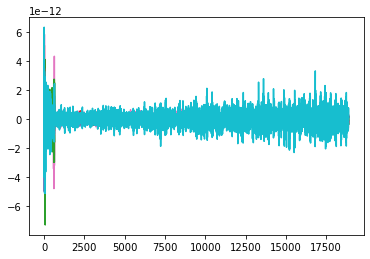

In [17]:
T     = np.array([t for t in spatiotemp_mesh]) # 
V_app = ot.DualLinearCombinationFunction(fPCA.getModes(), np.array(XiLambda).T) # TO reconstruct the signal

for k in range(process_sample.getSize()): 
    res = process_sample[k].getValues() - V_app .getMarginal(k)(T)
    plt.plot (res)

In [ ]:
#mode_0_onesubject = np.asarray(fPCA.getModesAsProcessSample()[0])

### <font color='green'> Etape 2: PCA - erreur de troncature</font>

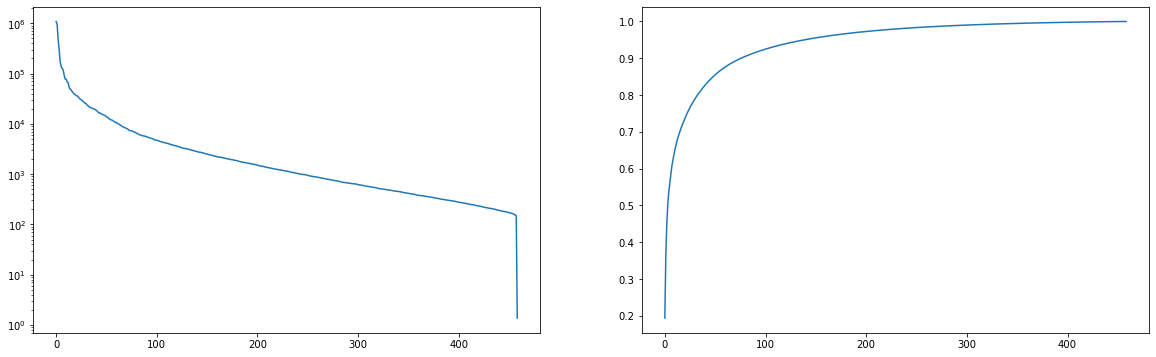

In [18]:
vp      = fPCA.getEigenValues() #  getEigenValues method enables to obtain the K first eigenvalues of the Karhunen Loeve decomposition
pVar    = np.cumsum(vp) / np.sum(vp)
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].semilogy(vp)
ax[1].plot (pVar)

## <font color='blue'> Projection of driving and braking fields </font>

In [19]:
NPeeg_b_C = NPeeg_b-NPeeg_b.mean(axis=1).reshape(-1,1) # 
NPeeg_d_C = NPeeg_d-NPeeg_d.mean(axis=1).reshape(-1,1) # 

In [187]:
NPeeg_d_C.shape

(13570, 320)

In [20]:
mu_t_b = compute_mu_t(NPeeg_b_C,nn_channels)
mu_t_d = compute_mu_t(NPeeg_d_C,nn_channels)

In [25]:
values_brake = transform_mesh_format(NPeeg_b_C,mu_t_b,nSample_b,nn_channels)
values_drive = transform_mesh_format(NPeeg_d_C,mu_t_d,nSample_d,nn_channels)

### Brake field

In [26]:
# OpenTurns:
dim_ch_in = 1 # corresponds to process_sample
dim_ch_out = 1 # corresponds to  field
process_sample_brake = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), nSample_b, dim_ch_in) 
field_brake          = ot.Field(ot.Mesh(spatiotemp_mesh), dim_ch_out) #le 1 correspond a la dimension du champ en sortie
for k in range(process_sample_brake.getSize()):
    aux = []
    for j in range(nn_channels):
        aux.append(values_brake[k][:,j])
    field_brake.setValues(np.array(aux).reshape(-1,1))
    process_sample_brake[k] = field_brake

### Drive field

In [27]:
# OpenTurns:
dim_ch_in = 1 # corresponds to process_sample
dim_ch_out = 1 # corresponds to  field
process_sample_drive = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), nSample_d, dim_ch_in) 
field_drive          = ot.Field(ot.Mesh(spatiotemp_mesh), dim_ch_out) #le 1 correspond a la dimension du champ en sortie
for k in range(process_sample_drive.getSize()):
    aux = []
    for j in range(nn_channels):
        aux.append(values_drive[k][:,j])
    field_drive.setValues(np.array(aux).reshape(-1,1))
    process_sample_drive[k] = field_drive

### Probability laws 

In [175]:
Xi_drive       = fPCA.project(process_sample_drive)
Xi_brake       = fPCA.project(process_sample_brake)

In [169]:
np.array(Xi_drive).shape[0]

(230, 459)

In [180]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
Xi_con = np.concatenate((np.array(Xi_drive),np.array(Xi_brake)))
y = np.empty([np.array(Xi_drive).shape[0]+np.array(Xi_brake).shape[0], 1],dtype=int)
y[:np.array(Xi_drive).shape[0]]=0
y[np.array(Xi_drive).shape[0]:]=1


In [182]:
clf = LinearDiscriminantAnalysis()
clf.fit(Xi_con, y)
LinearDiscriminantAnalysis()
#print(clf.predict([[-0.8, -1]]))

/Users/obando_c/anaconda3/envs/advisedlib-env/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [185]:
clf.score(Xi_con, y)

0.49782608695652175

In [158]:
np.asarray(Xi_diff)

array([[ 6.82645592e-01,  5.22513100e-01,  4.87392273e-01, ...,
        -2.12758666e+00,  1.46094766e+00,  2.06350368e+00],
       [-6.19023190e-02, -1.09449161e-01,  1.24566553e+00, ...,
         2.23191082e+00, -7.20700163e-01,  2.07604909e+00],
       [ 4.98762087e-01, -6.07062503e-02, -8.69483205e-01, ...,
         4.76746657e-01, -6.30469989e-01,  2.04400270e+00],
       ...,
       [-4.01108873e-01, -8.26269188e-01,  3.07403212e-01, ...,
        -1.79364870e+00,  3.57983798e-01,  2.00277253e+00],
       [ 1.29520615e-01, -2.85649986e-01, -1.83175525e+00, ...,
        -1.14394261e-01, -9.51099760e-01,  2.01115791e+00],
       [-1.39981414e+00, -1.41409135e+00,  2.01984236e+00, ...,
         1.44938582e-01, -2.38936713e+00, -4.57488048e+02]])

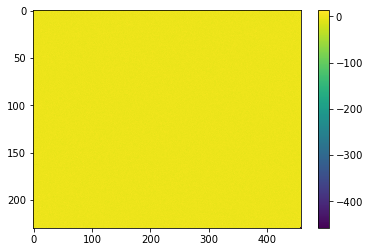

In [161]:
plt.imshow(np.asarray(Xi_diff), aspect='auto')
plt.colorbar()

In [165]:
np.asarray(Xi_diff).shape

(230, 459)

In [147]:
#Avec 2 modes
nModes = 2
X_brake      = Xi_brake.getMarginal ([k for k in range (nModes)])
X_drive      = Xi_drive.getMarginal ([k for k in range (nModes)])

dist_brake   = ot.KernelSmoothing().build(X_brake)
dist_drive   = ot.KernelSmoothing().build(X_drive)

R_brake     = np.array(dist_brake.computePDF(Xi_brake[:,:nModes]))
R_drive     = np.array(dist_drive.computePDF(Xi_drive[:,:nModes]))
print(R_brake.shape)
print(R_drive.shape)

(230, 1)
(230, 1)


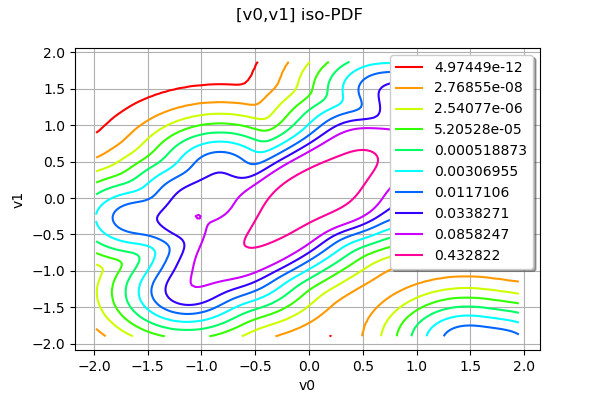

In [149]:
dist_brake.drawPDF()

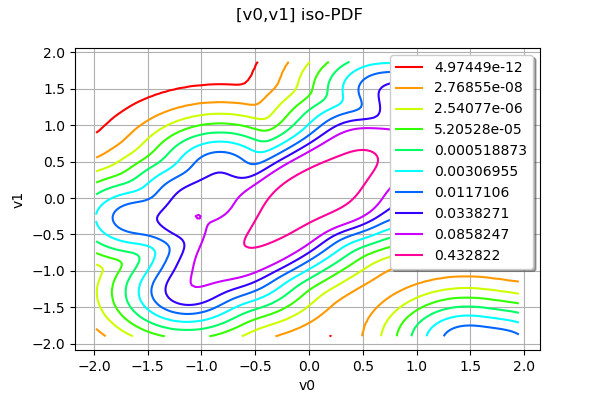

In [150]:
dist_drive.drawPDF()

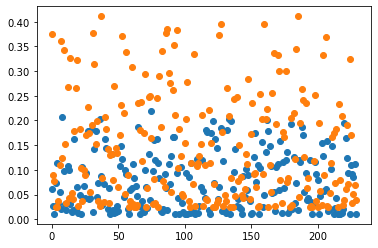

In [143]:
plt.plot(range(len(R_brake)),R_brake,'o')
plt.plot(range(len(R_drive)),R_drive,'o')

## <font color='blue'> La détection d'anomalies </font>

In [14]:
#Avec 2 modes
nModes = 2
X      = Xi.getMarginal ([k for k in range (nModes)])
dist   = ot.KernelSmoothing().build(X)
R      = np.array(dist.computePDF(Xi[:,:nModes]))

Anomalies =[]
for i in range (nSample-1):
    if (dist.computePDF(Xi[i,:nModes]) == R.min()):
        Anomalies.append(i)
print (Anomalies)

[139, 173]


### <font color='green'> Minimum Level Set </font>

On prend 2 modes (c'est plus facile pour visualiser), et on cherche la ligne de niveau qui minimise la surface sur le plan $\xi [0]$ x $\xi [1]$.

Ensuite on peut tester sur pour un signal donné, sa projection sur les 2 axes principaux est à l'intérieur ou à l'extérieur de cette surface.

 Nb Outlier =  0


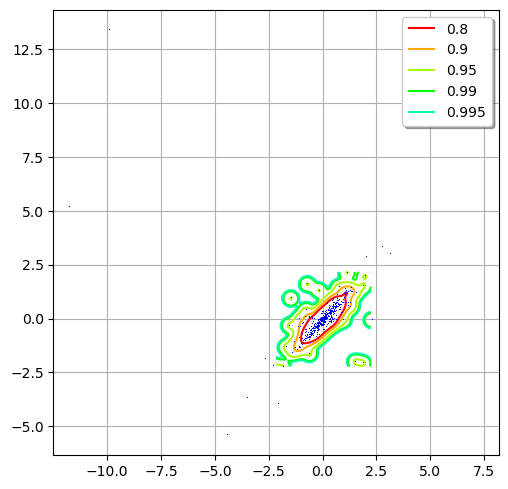

In [145]:
import openturns.viewer as otv 

#Avec 2 modes
nModes = 2
X      = Xi.getMarginal ([k for k in range (nModes)])
dist   = ot.KernelSmoothing().build(X)
R      = np.array(dist.computePDF(Xi[:,:nModes]))

Xin = {}; Xout = {};
Inside = []; Outside = []
ot.ResourceMap.SetAsUnsignedInteger("Distribution-MinimumVolumeLevelSetSamplingSize", 10000)
palette = ot.Contour.BuildDefaultPalette(8)
graph = ot.Graph("","","", True, "topright")
contour = dist.drawPDF().getDrawable(0)
for k, u in enumerate( [.8, .9, .95, .99, .995]):

    l, t = dist.computeMinimumVolumeLevelSetWithThreshold(u)
    contour.setLevels([t])
    contour.setColor(palette[k])
    contour.setLegend(str(u))
    graph.add(contour)
Xin = ot.Sample(0,nModes)
Xout = ot.Sample(0,nModes)
for i in range(Xi.getSize()):
    x = Xi[i][0:nModes]
    if l.contains(x): 
        Xin.add (x)
        Inside.append (i)
    else:
        Xout.add(x)
        Outside.append (i)

cloud = ot.Cloud(Xin)
cloud.setPointStyle('dot')
cloud.setColor('blue')
graph.add(cloud)
view = otv.View(graph, (800, 600), square_axes=True)
print (" Nb Outlier = ", len (Xout))

## <font color='blue'> All subjects </font>

In [16]:
df_eeg_events_file = path_data_mat + 'fromJupyter/df_eeg_only_events_all_subjects.csv'# Corresponds to VPja

Import data

In [17]:
df_eeg_events = pd.read_csv( df_eeg_events_file )

time_int = df_eeg_events.shape[1] #
nn_channels = 59

NPeeg = []
nSample = int(df_eeg_events.shape[0]/59)
for i in range(nSample):
    for k in range(nn_channels):
        NPeeg.append(np.asarray(df_eeg_events)[i * 59 + k,:time_int])
NPeeg = np.asarray(NPeeg)

Normalize data

In [18]:
NPeegC = NPeeg-NPeeg.mean(axis=1).reshape(-1,1) # 
mu_t = []
x = np.arange(0, NPeegC.shape[0])
for k in range(nn_channels):
    n= x[(x % nn_channels == k) ] 
    mu_t.append(NPeegC[n,:].mean(axis=0)) 
mu_t = np.array(mu_t)

Format data

In [19]:
spatiotemp_mesh = []
for p in pos3d_eegChannels[:nn_channels]: #
    xi, yi, zi = tuple(p)
    for ti in range(time_int):
        spatiotemp_mesh.append([xi, yi, zi, ti])
        
values = []
for k in range(nSample):
    start = k * nn_channels
    end = start + nn_channels
    values.append( (NPeegC[start:end,:] - mu_t).T) # T

OpenTurns:

In [20]:
# OpenTurns:
dim_ch_in = 1 # corresponds to process_sample
dim_ch_out = 1 # corresponds to  field
process_sample = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), nSample, dim_ch_in) 
field          = ot.Field(ot.Mesh(spatiotemp_mesh), dim_ch_out) #le 1 correspond a la dimension du champ en sortie
for k in range(process_sample.getSize()):
    aux = []
    for j in range(nn_channels):
        aux.append(values[k][:,j])
    field.setValues(np.array(aux).reshape(-1,1))
    process_sample[k] = field

In [21]:
s = 0.0 # 
w_v = np.ones(nn_channels*time_int) # verticesWeights
algo = ot.KarhunenLoeveSVDAlgorithm(process_sample,w_v, s) #0.0 (=s) correspond au threshold sur les valeurs propres
algo.run()

fPCA     = algo.getResult() # The structure containing all the results of the Fredholm problem
Xi       = fPCA.project(process_sample) # Project a function or a field on the eigenmodes basis.
XiLambda = Xi * ot.Point([np.sqrt(x) for x in fPCA.getEigenValues()])

In [22]:
mode1_all = np.asarray(fPCA.getModesAsProcessSample()[0])

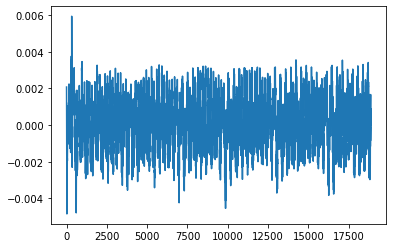

In [24]:
plt.plot(mode1_all - mode_0_onesubject) # Doesn’t seem like the same basis 

Plot some residuals (to big to plot)

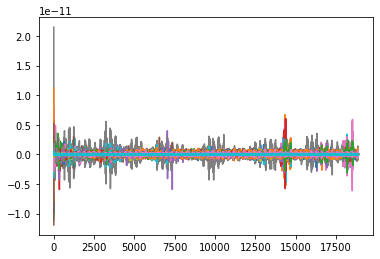

In [24]:
T     = np.array([t for t in spatiotemp_mesh]) # 
V_app = ot.DualLinearCombinationFunction(fPCA.getModes(), np.array(XiLambda).T) # TO reconstruct the signal

#for k in range(process_sample.getSize()): 
for k in range(500):  # Take only some examples to plot faster
    res = process_sample[k].getValues() - V_app .getMarginal(k)(T)
    plt.plot (res)

Compute mean residuals and plot

In [29]:
res_mean = []
for k in range(process_sample.getSize()):  # Take only some examples to plot faster
    res = process_sample[k].getValues() - V_app .getMarginal(k)(T)
    res_mean.append(np.asarray(res).mean())

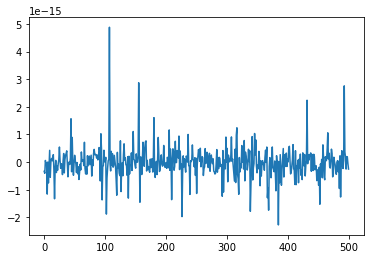

In [32]:
plt.plot(res_mean)